# Import-Export Analysis
To model the wheat price on the danish market, it might be valuable
to include features that give an indication of supply and demand. 
The assumption is, that the quantities of imported and exported wheat
can give such indications. 

The idea is to identify the countries with the largest import
of wheat from Denmark and then identify from what other countries they
import wheat. With data on wheat production in those countries, it
might be possible to model how much wheat will hit the market in the future. 

### Underlying assumption:
- Countries import majority of wheat from a few exporters
- Those countries are mostly the same through the years


### Findings:

##### Top imports of DK wheat:
- Spain 
- Germany
- Netherlands
- Great Britain
- Ireland

##### Large exporters to top importers of  DK wheat (that aren't also importers:
- Bulgaria  
- Ukraine 
- Czech Republic 
- Poland
- Belgium
- Romania


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
sns.set_context("talk")

df = pd.read_csv("../grain-price-data/raw/wheat_importExport_EU_raw.csv")
df.head()

,PERIOD,REPORTER,PARTNER,PRODUCT,FLOW,INDICATORS,Value,Flag and Footnotes
0,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,34850860,NaN
1,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,10476666,NaN
2,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN
3,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,:,NaN
4,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AE,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN


### DK Wheat Export 2019

The dataset contains yearly data on all EU countries import and export of wheat from 2000 to 2020.
First we take a look at wheat export of 2019 from denmark:

In [5]:
# drop rows without data and convert 'Value' column to numeric
df = df.drop(df[(df.Value == ':') | (df.Value == '0')].index)
df['Value'] = pd.to_numeric(df['Value'])

# Select DK exports
exports_DK = df.loc[(df['REPORTER'] == 'DENMARK') & ( df['FLOW'] == 'EXPORT')]

# get a list of the years that is easy to iterate through
periods = exports_DK['PERIOD'].unique()

# get exports of 2019 and group them by import country
exports_DK_2019 = exports_DK.loc[exports_DK['PERIOD'] == periods[-1]]
exports_DK_2019 = exports_DK_2019.groupby('PARTNER')['Value'].sum()
exports_DK_2019 = exports_DK_2019.sort_values(ascending=False)[1:]
exports_DK_2019


PARTNER
ES    3042527
SE     838205
NL     819636
FR     639093
LT     420075
IE     280094
DE     276666
PL     144652
FI     111009
IS     109237
GB      77294
NO      70137
BE      39426
LV       2216
AT        260
FO          7
CY          4
GL          4
Name: Value, dtype: int64

Spain is by far the largest importer of wheat from Denmark in 2019. The result includes the aggreate value for world, but Eurostat cautions that it is not computed when data is pulled, but stored in the database, so it might not be completely accurate.

Let's see how the importing countries are distributed in terms of the quantity:

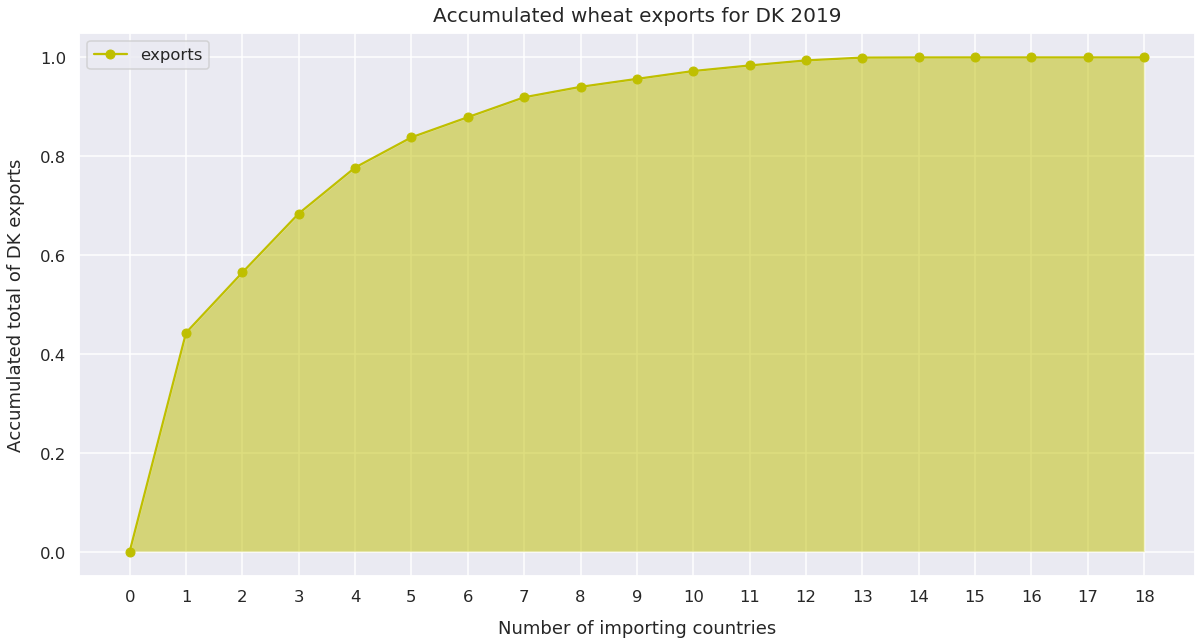

In [7]:
exports_cumulative = (exports_DK_2019.astype(int).cumsum() / 
                      exports_DK_2019.astype(int).sum()).values
exports_cumulative = np.insert(exports_cumulative, 0 ,0)


plt.title("Accumulated wheat exports for DK 2019", y=1.01, fontsize=20)
plt.ylabel("Accumulated total of DK exports", labelpad=15)
plt.xlabel("Number of importing countries", labelpad=15)
plt.rcParams['figure.figsize'] = [20,10]
plt.xticks(range(len(exports_cumulative)))
plt.plot(exports_cumulative,'yo-', label='exports')
plt.fill_between(range(len(exports_cumulative)),exports_cumulative,facecolor='y', alpha=0.5)

plt.legend()
plt.show()

For 2019 it appears that five importing countries account for more than 80% of the total wheat exports from DK.


### Share of wheat import for largest importers of DK wheat
Let's see how much the top imports account for during the other years. Since this is to get an idea of what ountries might be relevant, it should be limited to the timeframe of the training set, which will be 2000-2011 with the current data set.

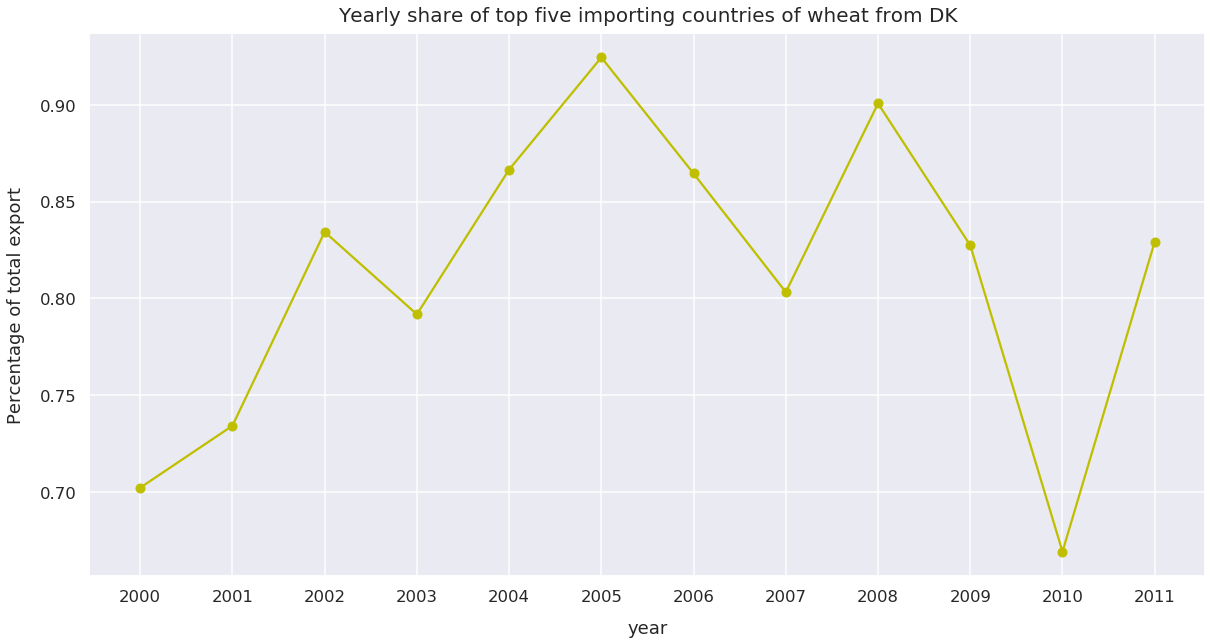

In [8]:


numberOfImporters = 5
topImporterShare = []
periods = periods[:12]

for i, period in enumerate(periods):
    exports_DK_year = exports_DK.loc[exports_DK['PERIOD'] == period]
    exports_DK_year = exports_DK_year.groupby('PARTNER')['Value'].sum()
    
    # sort and leave out the aggregated world value
    exports_DK_year = exports_DK_year.astype(int).sort_values(ascending=False)[1:]
    total_exports = exports_DK_year.astype(int).sum()
    top_exports = exports_DK_year[:numberOfImporters].sum()
    export_percentage = top_exports / total_exports
    topImporterShare.append(export_percentage)
        
plt.title("Yearly share of top five importing countries of wheat from DK", y=1.01, fontsize=20)

plt.rcParams['figure.figsize'] = [20,10]
ax = plt.axes()
plt.ylabel("Percentage of total export", labelpad=15)
plt.xlabel("year", labelpad=15)
years = list(map(lambda x : int(x + 2000), list(range(len(periods)))))
ax.set_xticks(years)
plt.plot(years, topImporterShare, 'yo-', label='exports')
plt.show()


The five top importers account for more than 70% of danish exports for all years except 2010. Looking at the top six importers, it is over 75% and 2010 is over 70%.


### Largest importers of DK wheat over time

Let's take a look at the top importers over the years:


In [9]:
exports_DK_all = exports_DK.loc[exports_DK['PERIOD'].isin(periods)]  
exports_DK_all = exports_DK_all.groupby(['PERIOD','PARTNER']).sum().sort_values(['PERIOD','Value'],ascending=False)
print(exports_DK_all.groupby('PERIOD').head(7))


                           Value  Flag and Footnotes
PERIOD         PARTNER                              
Jan.-Dec. 2011 WORLD    10053329                 0.0
               DE        2574165                 0.0
               NL        2221890                 0.0
               PL        1480863                 0.0
               ES        1290825                 0.0
...                          ...                 ...
Jan.-Dec. 2000 BY        1598750                 0.0
               EE         584493                 0.0
               IR         551955                 0.0
               NL         539428                 0.0
               NO         537995                 0.0

[84 rows x 2 columns]


Top importers seem to be somewhat the same from year to year, but changes over the years lead to some different importers over time. 

Considering that the largest importers of the most recent years are probably also the most likely in the upcoming year, it might be worth weighting the imported amount based on year.

For this I will use exponential weighting, such that latest year has weight of a^0, then a^1, a^2... a^k where k is the number of years from the last year in the series and a is a real value 0<a<1. It is somewhat arbitrarily chosen. The weights are normalized a^k / 1-a.

In [10]:
def getTopCountries(country, flow):
    data = df.loc[(df['REPORTER'] == country) & ( df['FLOW'] == flow)]

    a = 0.90
    weights = list(a ** i for i in range( len(periods)))
    weights = list(reversed(weights))

    result = []   
    numberOfYears = len(periods)
    for i, period in enumerate(periods):
        dataForPeriod = data.loc[data['PERIOD'] == period]  
        dataForPeriod = dataForPeriod.groupby(['PARTNER']).sum().sort_values('Value',ascending=False)
        # percentage of import multiplied by the weight
        exponent = (-1 * (i-numberOfYears)) 
        dataForPeriod = (dataForPeriod['Value'][1:] / dataForPeriod['Value'][0]) * (a**exponent/(1-a)) #

        result.append(dataForPeriod)
        
    result= pd.concat(result)
    result = result.groupby('PARTNER').sum().sort_values(ascending=False)
    return result    


In [11]:
getTopCountries('DENMARK', 'EXPORT').head(8)

PARTNER
DE    20.262076
NL    10.448627
ES     7.203310
NO     4.948856
FR     3.051645
PL     3.014472
SE     2.518325
GB     1.616007
Name: Value, dtype: float64

The top five importers are Germany, Netherlands, Spain, Norway and France. Great Britain is also on the list, but far down. Since brexit took effect early this year, British imports of EU commodities will presumably decrease even further in the future. 

Sweden is also relevant even though their imports aren't as large. They are however a neighboring country, so they will probably continue import wheat from DK. The dataset does not hold import data for Norway, because they aren't in the EU.

### Find other exporters to the importers of DK wheat

Next, let's put these countries into a list find out what countries export to these five countries.

In [15]:
topImporters = ['GERMANY', 'NETHERLANDS','SPAIN', 'FRANCE', 'POLAND', 'SWEDEN']

topCount = 4
exporterList = []
for importingCountry in topImporters:
    exporters = getTopCountries(importingCountry, 'IMPORT').head(topCount)
    exporterList.append(exporters)
    
    print(importingCountry)
    print(exporters)
    
exporterList = pd.concat(exporterList)
uniques1 = list(exporterList.index.unique())
print("\nUniques:")
print(uniques1)

GERMANY
PARTNER
FR    15.882932
CZ    13.131547
PL     6.052671
DK     5.479077
Name: Value, dtype: float64
NETHERLANDS
PARTNER
FR    31.449341
DE    17.547713
GB     5.942079
BE     4.940014
Name: Value, dtype: float64
SPAIN
PARTNER
FR    15.691925
GB    11.113183
UA    10.247351
US     4.828329
Name: Value, dtype: float64
FRANCE
PARTNER
DE    29.477694
ES     7.925498
GB     5.495124
BE     5.212630
Name: Value, dtype: float64
POLAND
PARTNER
CZ    20.618072
DE    15.806053
SK     7.783399
HU     5.364469
Name: Value, dtype: float64
SWEDEN
PARTNER
DK    16.760835
DE    13.792423
ES     6.996375
RU     3.284821
Name: Value, dtype: float64

Uniques:
['FR', 'CZ', 'PL', 'DK', 'DE', 'GB', 'BE', 'UA', 'US', 'ES', 'SK', 'HU', 'RU']


It seems some of the largest importers of danish wheat are also among the largest exporters to some of the other importing countries. Namely France, Germany, Poland and Spain. Additional countries are Ukraine, Czech Republic, Belgium, Slovakia, Hungary, United States, Russia and Romania. 

This is the result, when looking at the top four. Lets see how it changes with only three:

In [18]:
topImporters = ['GERMANY', 'NETHERLANDS','SPAIN', 'FRANCE', 'POLAND', 'SWEDEN']

topCount = 3
exporterList = []
for importingCountry in topImporters:
    exporters = getTopCountries(importingCountry, 'IMPORT').head(topCount)
    exporterList.append(exporters)
    
    print(importingCountry)
    print(exporters)
    
exporterList = pd.concat(exporterList)
uniques2 = list(exporterList.index.unique())
print("\nUniques:")
print(uniques2)

GERMANY
PARTNER
FR    15.882932
CZ    13.131547
PL     6.052671
Name: Value, dtype: float64
NETHERLANDS
PARTNER
FR    31.449341
DE    17.547713
GB     5.942079
Name: Value, dtype: float64
SPAIN
PARTNER
FR    15.691925
GB    11.113183
UA    10.247351
Name: Value, dtype: float64
FRANCE
PARTNER
DE    29.477694
ES     7.925498
GB     5.495124
Name: Value, dtype: float64
POLAND
PARTNER
CZ    20.618072
DE    15.806053
SK     7.783399
Name: Value, dtype: float64
SWEDEN
PARTNER
DK    16.760835
DE    13.792423
ES     6.996375
Name: Value, dtype: float64

Uniques:
['FR', 'CZ', 'PL', 'DE', 'GB', 'UA', 'ES', 'SK', 'DK']


And the difference:

In [19]:
set(uniques1) - set(uniques2)

{'BE', 'HU', 'RU', 'US'}

Both US and Russia might be worth considering to include as it is a large exporter of wheat in general. Belgium is probably not crucial as it is only a top exporter to two of the five countries. 